In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/powerstation/2020_6__.xlsx
/kaggle/input/powerstation/Korea_Powerstation/target.xlsx
/kaggle/input/powerstation/Korea_Powerstation/PowerStation.csv
/kaggle/input/powerstation/Korea_Powerstation/PowerStation.xls
/kaggle/input/powerstation/Korea_Powerstation/gc_poltnsrc_dust_202005.csv


In [84]:

import matplotlib.pyplot as plt
from numpy import newaxis
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import TimeDistributed

from sklearn.preprocessing import MinMaxScaler 

import pylab
import os

In [85]:
plt.rcParams["figure.figsize"] = (7.5,5)
plt.style.use('seaborn')

pylab.rc('figure', figsize=(10,7))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [86]:
training_dataset=pd.read_excel('/kaggle/input/powerstation/Korea_Powerstation/target.xlsx',index_col = '날짜', parse_dates = ['날짜'])
training_data_drop = training_dataset.dropna(subset = ['PM10'])
training_data=training_data_drop.iloc[:,0:1].values
#training_data = np.expand_dims(pm10, axis=1)
training_data.shape

(2229, 1)

In [87]:
print(training_dataset['PM10'].isnull().sum()/2342*100)
print(training_dataset['PM2.5'].isnull().sum()/2342*100)
print(training_dataset['오 존'].isnull().sum()/2342*100)
print(training_dataset['이산화질소'].isnull().sum()/2342*100)
print(training_dataset['일산화탄소'].isnull().sum()/2342*100)
print(training_dataset['아황산가스'].isnull().sum()/2342*100)

4.824935952177626
59.82066609735269
0.1707941929974381
2.69000853970965
0.29888983774551664
1.067463706233988


In [88]:
training_dataset

,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
날짜,,,,,,
2014-01-01,100.0,NaN,0.017,0.023,0.6,0.009
2014-01-02,48.0,NaN,0.016,0.022,0.5,0.007
2014-01-03,63.0,NaN,0.006,0.033,0.7,0.008
2014-01-04,37.0,NaN,0.018,0.016,0.4,0.005
2014-01-05,43.0,NaN,0.018,0.016,0.5,0.005
...,...,...,...,...,...,...
2020-05-27,36.0,10.0,0.040,0.012,0.3,0.003
2020-05-28,48.0,16.0,0.048,0.014,0.3,0.003
2020-05-29,49.0,16.0,0.034,0.015,0.3,0.003


In [89]:
training_data

array([[100.],
       [ 48.],
       [ 63.],
       ...,
       [ 49.],
       [ 58.],
       [ 57.]])

In [90]:
ababab = pd.DataFrame(training_data_drop['PM10'])
ababab

,PM10
날짜,
2014-01-01,100.0
2014-01-02,48.0
2014-01-03,63.0
2014-01-04,37.0
2014-01-05,43.0
...,...
2020-05-27,36.0
2020-05-28,48.0
2020-05-29,49.0


Text(0.5, 0, 'ATMOSPHERE')

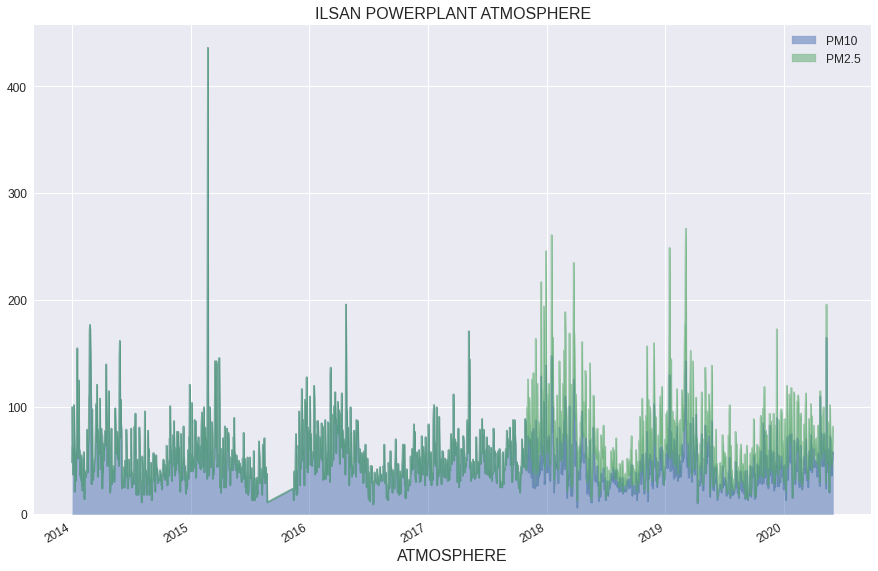

In [91]:
training_data_drop[["PM10","PM2.5"]].plot.area(figsize=(15,10),alpha=0.5);
plt.title('ILSAN POWERPLANT ATMOSPHERE')
plt.xlabel('ATMOSPHERE')

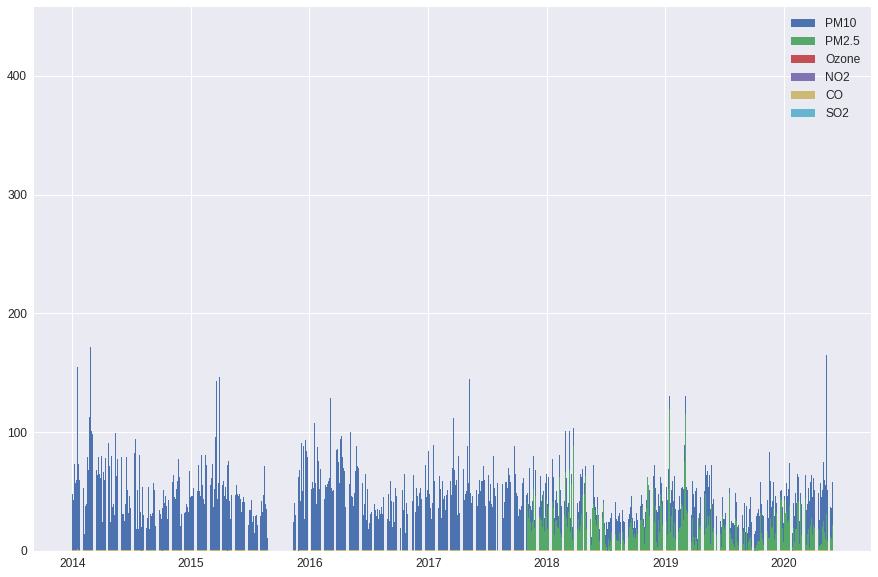

In [92]:
plt.figure(figsize = (15,10))
plt.bar(training_data_drop.index.values, training_data_drop['PM10'], label = 'PM10')
plt.bar(training_data_drop.index.values, training_data_drop['PM2.5'], label = 'PM2.5')
plt.bar(training_data_drop.index.values, training_data_drop['오 존'], label = 'Ozone')
plt.bar(training_data_drop.index.values, training_data_drop['이산화질소'], label = 'NO2')
plt.bar(training_data_drop.index.values, training_data_drop['일산화탄소'], label = 'CO')
plt.bar(training_data_drop.index.values, training_data_drop['아황산가스'], label = 'SO2')
plt.legend()

In [93]:
pie_data = [len(training_data_drop['PM10']),len(training_data_drop['PM2.5']),len(training_data_drop['오 존']),len(training_data_drop['이산화질소']),len(training_data_drop['일산화탄소']),len(training_data_drop['아황산가스'])]

In [94]:
pie_categories = ['PM10','PM2.5','Ozone','NO2','CO','SO2']

([<matplotlib.patches.Wedge at 0x7fd4690acc90>,
 [Text(0.9526279355804298, 0.5500000148652441, 'PM10'),
  Text(-5.149471629032507e-08, 1.0999999999999988, 'PM2.5'),
  Text(-0.9526279870751434, 0.5499999256737774, 'Ozone'),
  Text(-0.952627884085708, -0.5500001040567056, 'NO2'),
  Text(1.5448414935947287e-07, -1.0999999999999892, 'CO'),
  Text(0.9526280385698485, -0.5499998364823061, 'SO2')])

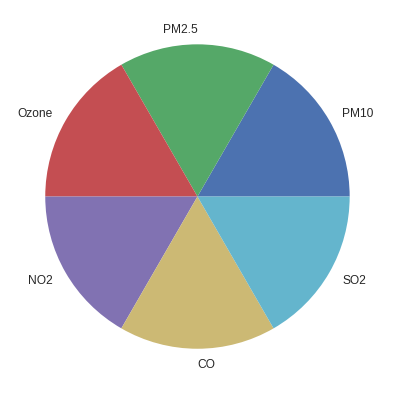

In [95]:
plt.pie(pie_data, labels=pie_categories)

In [96]:
training_data_drop

,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
날짜,,,,,,
2014-01-01,100.0,NaN,0.017,0.023,0.6,0.009
2014-01-02,48.0,NaN,0.016,0.022,0.5,0.007
2014-01-03,63.0,NaN,0.006,0.033,0.7,0.008
2014-01-04,37.0,NaN,0.018,0.016,0.4,0.005
2014-01-05,43.0,NaN,0.018,0.016,0.5,0.005
...,...,...,...,...,...,...
2020-05-27,36.0,10.0,0.040,0.012,0.3,0.003
2020-05-28,48.0,16.0,0.048,0.014,0.3,0.003
2020-05-29,49.0,16.0,0.034,0.015,0.3,0.003


In [97]:
groups=training_data_drop['PM10'].groupby(pd.Grouper(freq='A'))

years={}
for name, group in groups:
    years[name.year] = group.values
    
years[2017]=np.append(years[2017],years[2017][-1])
years[2018]=np.append(years[2018],years[2018][-1]) 

years=pd.DataFrame.from_dict(years, orient='index')

In [98]:
years

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
2014,100.0,48.0,63.0,37.0,43.0,100.0,102.0,73.0,21.0,45.0,...,37.0,49.0,60.0,33.0,44.0,72.0,67.0,121.0,114.0,45.0
2015,57.0,40.0,46.0,52.0,104.0,46.0,40.0,52.0,53.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,79.0,60.0,110.0,92.0,46.0,75.0,53.0,52.0,53.0,45.0,...,56.0,45.0,49.0,36.0,51.0,53.0,NaN,NaN,NaN,NaN
2017,67.0,84.0,73.0,56.0,48.0,32.0,57.0,36.0,58.0,35.0,...,29.0,57.0,102.0,139.0,65.0,65.0,NaN,NaN,NaN,NaN
2018,39.0,45.0,39.0,50.0,70.0,62.0,73.0,59.0,42.0,33.0,...,32.0,44.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,43.0,43.0,54.0,57.0,54.0,46.0,65.0,43.0,61.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,28.0,42.0,46.0,42.0,33.0,22.0,13.0,15.0,57.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


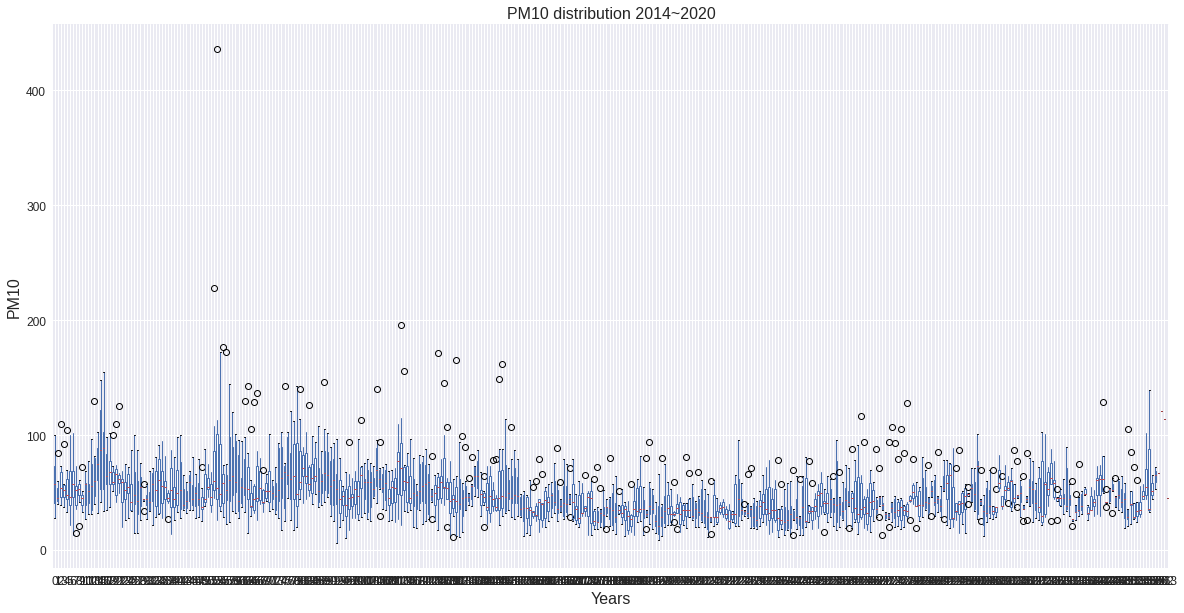

In [99]:
years.plot.box(figsize=(20,10))
plt.title('PM10 distribution 2014~2020')
plt.ylabel('PM10')
plt.xlabel('Years')
plt.show()

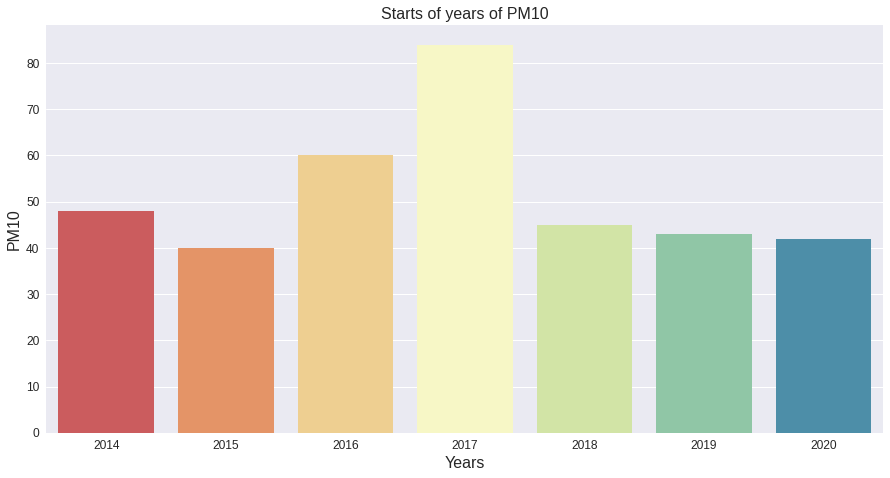

In [100]:
plt.figure(figsize=(15,7.5))
sns.barplot(years.iloc[:,-1].index,years.iloc[:,1].values,palette='Spectral')
plt.title('Starts of years of PM10')
plt.ylabel('PM10')
plt.xlabel('Years')
plt.show()

In [101]:
years

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
2014,100.0,48.0,63.0,37.0,43.0,100.0,102.0,73.0,21.0,45.0,...,37.0,49.0,60.0,33.0,44.0,72.0,67.0,121.0,114.0,45.0
2015,57.0,40.0,46.0,52.0,104.0,46.0,40.0,52.0,53.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,79.0,60.0,110.0,92.0,46.0,75.0,53.0,52.0,53.0,45.0,...,56.0,45.0,49.0,36.0,51.0,53.0,NaN,NaN,NaN,NaN
2017,67.0,84.0,73.0,56.0,48.0,32.0,57.0,36.0,58.0,35.0,...,29.0,57.0,102.0,139.0,65.0,65.0,NaN,NaN,NaN,NaN
2018,39.0,45.0,39.0,50.0,70.0,62.0,73.0,59.0,42.0,33.0,...,32.0,44.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,43.0,43.0,54.0,57.0,54.0,46.0,65.0,43.0,61.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,28.0,42.0,46.0,42.0,33.0,22.0,13.0,15.0,57.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


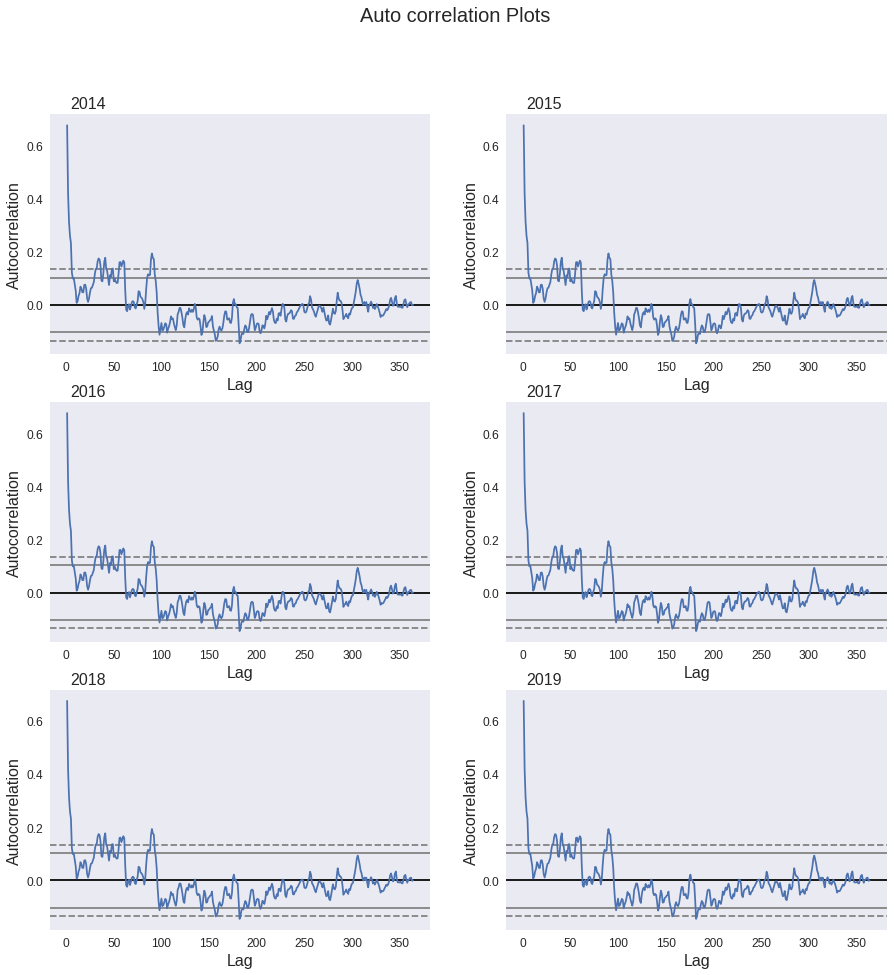

In [102]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(15,15))
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[0,0])
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[0,1])
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[1,0])
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[1,1])
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[2,0])
pd.plotting.autocorrelation_plot(years.iloc[0],ax=ax[2,1])
fig.suptitle('Auto correlation Plots',fontsize=20)
ax[0,0].set_title('2014',X=0.1)
ax[0,1].set_title('2015',X=0.1)
ax[1,0].set_title('2016',X=0.1)
ax[1,1].set_title('2017',X=0.1)
ax[2,0].set_title('2018',X=0.1)
ax[2,1].set_title('2019',X=0.1)
#plt.rc('axes', titlesize=20)
plt.show()

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)


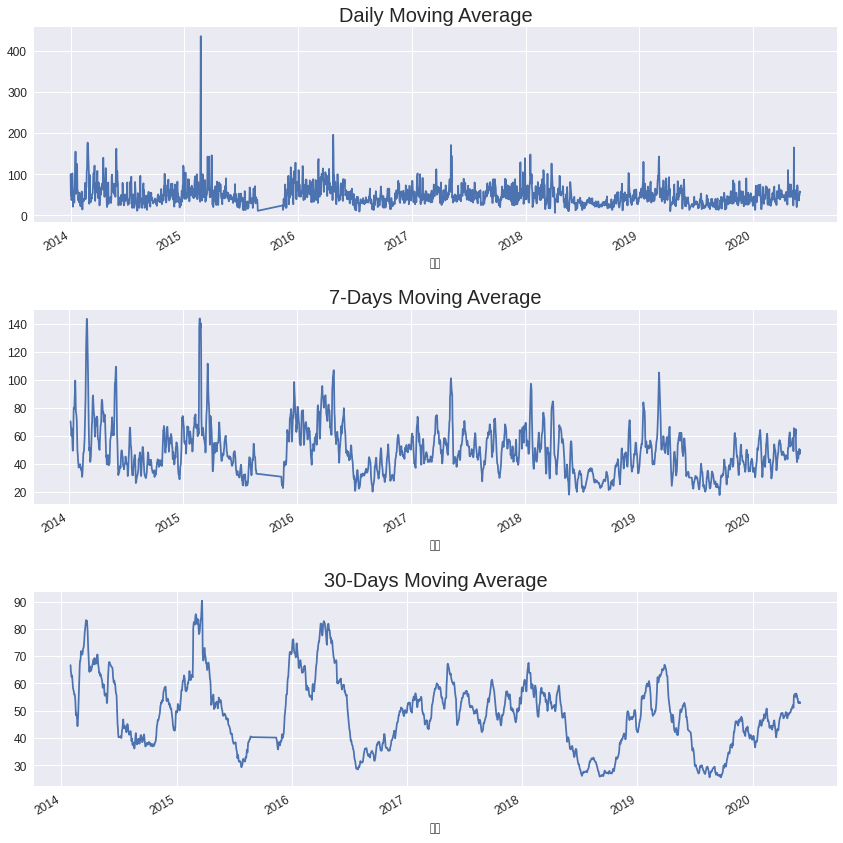

In [103]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(12,12))
training_data_drop['PM10'].rolling(window=1).mean().plot(ax=ax[0])
training_data_drop['PM10'].rolling(window=7).mean().plot(ax=ax[1])
training_data_drop['PM10'].rolling(window=30).mean().plot(ax=ax[2])
ax[0].set_title('Daily Moving Average',fontsize=20)
ax[1].set_title('7-Days Moving Average',fontsize=20)
ax[2].set_title('30-Days Moving Average',fontsize=20)
plt.tight_layout()

In [104]:
PM10_data = training_data_drop['PM10'].reset_index()
PM10_data.columns = ['ds','y']

In [105]:
PM10_data

,ds,y
0,2014-01-01,100.0
1,2014-01-02,48.0
2,2014-01-03,63.0
3,2014-01-04,37.0
4,2014-01-05,43.0
...,...,...
2224,2020-05-27,36.0
2225,2020-05-28,48.0
2226,2020-05-29,49.0
2227,2020-05-30,58.0


In [106]:
Trend_model=Prophet()
Trend_model.fit(PM10_data)

future_trend=Trend_model.make_future_dataframe(periods=365)
Trend_predict=Trend_model.predict(future_trend)

Text(0.5, 44.5, 'Years')

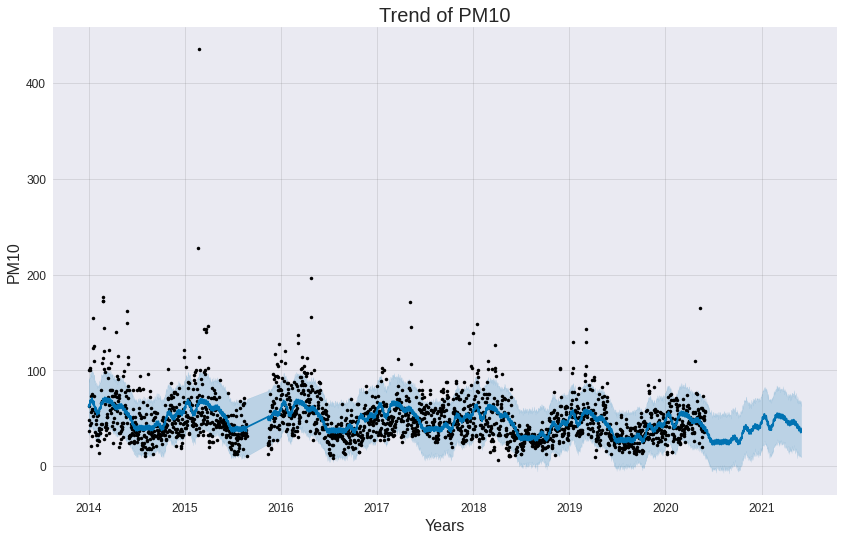

In [107]:
fig1=Trend_model.plot(Trend_predict,figsize=(12,7.5))
plt.title('Trend of PM10',fontsize=20)
plt.ylabel('PM10')
plt.xlabel('Years')

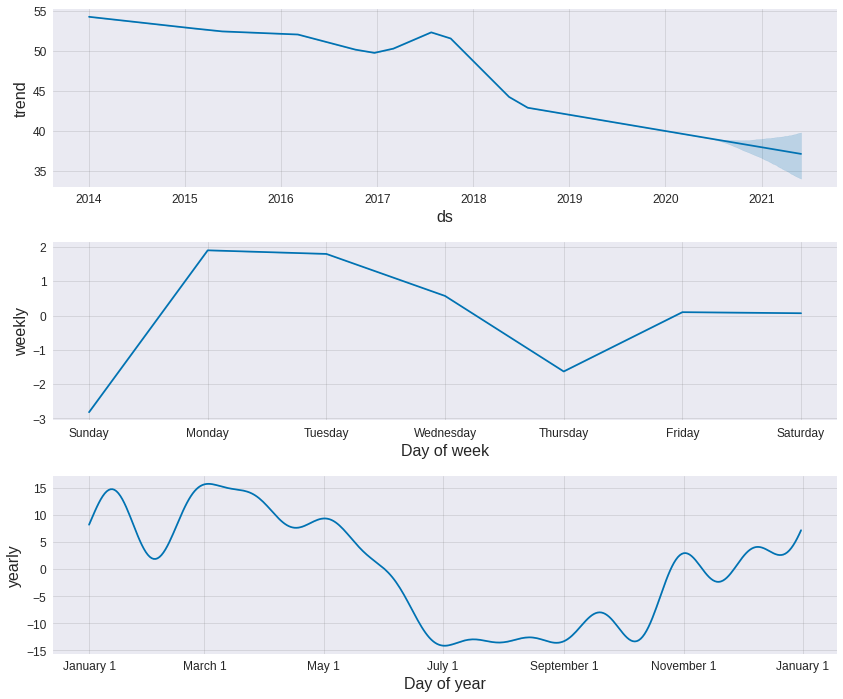

In [108]:
fig2=Trend_model.plot_components(Trend_predict,figsize=(12,10))

In [109]:

sc=MinMaxScaler(feature_range=(0,1))  ##Normalising
training_data=sc.fit_transform(training_data)

#Scaling

X_train=[]
y_train=[]
for i in range(60,len(training_data)):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])

X_train= np.array(X_train)
y_train=np.array(y_train)    

X_train=X_train.reshape((len(training_data)-60), 60, 1)


In [110]:
X_train.shape

(2169, 60, 1)

In [111]:
y_train.shape

(2169,)

In [112]:
"""
X_train=[]
y_train=[]
for i in range(30,len(training_data)):
    X_train.append(training_data[i-30:i,0])
    y_train.append(training_data[i,0])
    
X_train = np.array(X_train)
y_train = np.array(y_train)    
X_train=X_train.reshape((len(training_data)-30),30,1)
"""

'\nX_train=[]\ny_train=[]\nfor i in range(30,len(training_data)):\n    X_train.append(training_data[i-30:i,0])\n    y_train.append(training_data[i,0])\n    \nX_train = np.array(X_train)\ny_train = np.array(y_train)    \nX_train=X_train.reshape((len(training_data)-30),30,1)\n'

In [113]:
regressor= Sequential()

#Adding LSTM layers

regressor.add(LSTM(units=64,return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(TimeDistributed(Dense(1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=128,return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=128,return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=64))
regressor.add(Dropout(0.1))

regressor.add(Dense(1))

#Compiling RNN
regressor.compile(optimizer='adam',loss='mean_squared_error', metrics = ['mean_squared_error'])

In [114]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 1)             65        
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 1)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 128)          

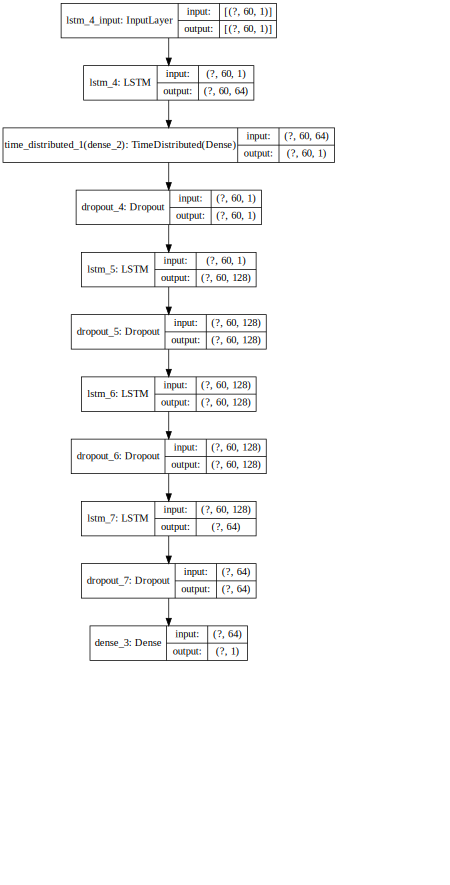

In [115]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(regressor, show_shapes=True).create(prog='dot', format='svg'))

In [116]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [117]:
regressor.fit(X_train,y_train,epochs=50,batch_size=32, callbacks=[es])

Epoch 1/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 2/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/50
68/68 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 6/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 7/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 8/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 9/50
68/68 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 10/50
68/68 [

In [118]:
tempA = training_dataset['2020':]['PM10']
tempB = training_dataset['2020':]['PM10']
tempA[:-31]

날짜
2020-01-01    28.0
2020-01-02    42.0
2020-01-03    46.0
2020-01-04    42.0
2020-01-05    33.0
              ... 
2020-04-26    45.0
2020-04-27    46.0
2020-04-28    48.0
2020-04-29    51.0
2020-04-30    45.0
Name: PM10, Length: 121, dtype: float64

In [119]:
len(tempB)

152

In [120]:
#tempA = training_data
#tempB = training_data
#tempA[:-31]

In [121]:
testA = np.array(tempA[:-31]) #20년 4월까지의 자료
testB = np.array(tempB) #20년 5월까지의 자료

In [122]:
print(testA.shape)
print(testB.shape)

(121,)
(152,)


In [123]:
testA1 = np.expand_dims(testA, axis = 1)
testB1 = np.expand_dims(testB, axis = 1)

testA2 = sc.fit_transform(testA1)
testB2 = sc.fit_transform(testB1)

In [124]:
testB2.shape

(152, 1)

In [125]:
#testA 데이터를 이용하여(2014~2020년 4월까지의 자료) 5월의 미세먼지 예상하기

#close_data = testA.reshape((-1))
close_data = testA2

def predict(num_prediction,look_back, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = tempA[:-31].index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecastA = predict(num_prediction, 60, regressor)
forecast_datesA = predict_dates(num_prediction)

In [126]:
#close_data = testB.reshape((-1))
close_data = testB2

def predict(num_prediction,look_back, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = tempB.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecastB = predict(num_prediction,60, regressor)
forecast_datesB = predict_dates(num_prediction)

In [127]:
testC2 = np.array(training_dataset['PM10'].iloc[-212:].values)
testC3 = testC2.reshape(-1,1)
testC4 = sc.transform(testC3)
testC4.shape

(212, 1)

In [128]:
close_dataT = testC4
prediction_listT = close_dataT[-testC4.shape[0]:]
xT = prediction_listT[-testC4.shape[0]:]
X_testT = []
for i in range(60,(60+len(tempB))):
    X_testT.append(xT[i-60:i,0])
X_testT = np.array(X_testT)
X_testT.shape
X_testT = X_testT.reshape(X_testT.shape[0],X_testT.shape[1],1)
X_testT.shape
outT = regressor.predict(X_testT)
outT.shape

(152, 1)

In [129]:
outT.shape

(152, 1)

In [130]:
outT2 = sc.inverse_transform(outT)
outT2.shape

(152, 1)

In [131]:
def predict_dates_outT(num_prediction):
    last_date = tempB.index.values[-1]+(1000000000*60*60*24)
    prediction_dates = pd.date_range(last_date, periods=num_prediction).tolist()
    return prediction_dates
outT_datesBT = predict_dates_outT(151)
outT_datesBT

[Timestamp('2020-06-01 00:00:00', freq='D'),
 Timestamp('2020-06-02 00:00:00', freq='D'),
 Timestamp('2020-06-03 00:00:00', freq='D'),
 Timestamp('2020-06-04 00:00:00', freq='D'),
 Timestamp('2020-06-05 00:00:00', freq='D'),
 Timestamp('2020-06-06 00:00:00', freq='D'),
 Timestamp('2020-06-07 00:00:00', freq='D'),
 Timestamp('2020-06-08 00:00:00', freq='D'),
 Timestamp('2020-06-09 00:00:00', freq='D'),
 Timestamp('2020-06-10 00:00:00', freq='D'),
 Timestamp('2020-06-11 00:00:00', freq='D'),
 Timestamp('2020-06-12 00:00:00', freq='D'),
 Timestamp('2020-06-13 00:00:00', freq='D'),
 Timestamp('2020-06-14 00:00:00', freq='D'),
 Timestamp('2020-06-15 00:00:00', freq='D'),
 Timestamp('2020-06-16 00:00:00', freq='D'),
 Timestamp('2020-06-17 00:00:00', freq='D'),
 Timestamp('2020-06-18 00:00:00', freq='D'),
 Timestamp('2020-06-19 00:00:00', freq='D'),
 Timestamp('2020-06-20 00:00:00', freq='D'),
 Timestamp('2020-06-21 00:00:00', freq='D'),
 Timestamp('2020-06-22 00:00:00', freq='D'),
 Timestamp

In [132]:
tempB.index.values[-1]+(1000000000*60*60*24)

numpy.datetime64('2020-06-01T00:00:00.000000000')

<function matplotlib.pyplot.show(*args, **kw)>

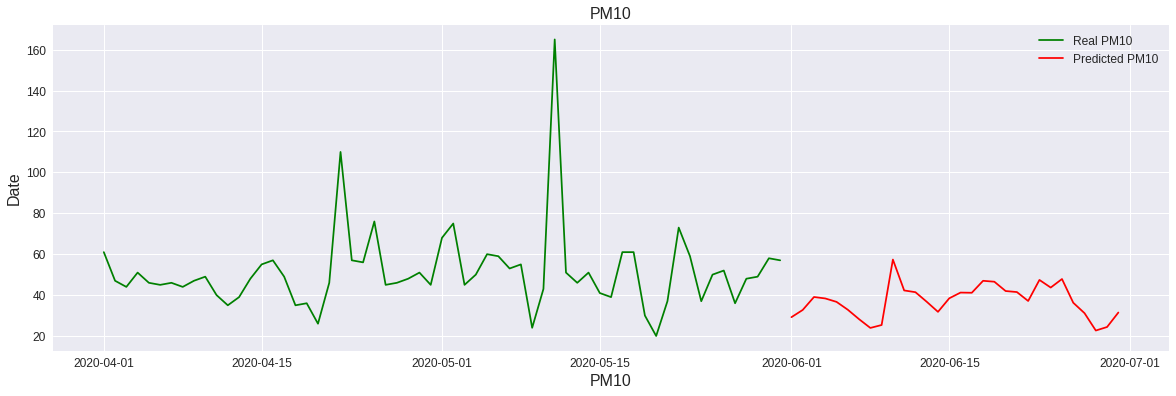

In [133]:
plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

In [134]:
forecastA1 = np.expand_dims(forecastA, axis = 1)
forecastB1 = np.expand_dims(forecastB, axis = 1)

In [135]:
forecastA1.shape

(31, 1)

In [136]:
forecastB1.shape

(31, 1)

In [137]:
training_dataset['2020':]['PM10']['2020-05-01']

68.0

In [138]:
forecastA2 = sc.inverse_transform(forecastA1)
forecastB2 = sc.inverse_transform(forecastB1)

<function matplotlib.pyplot.show(*args, **kw)>

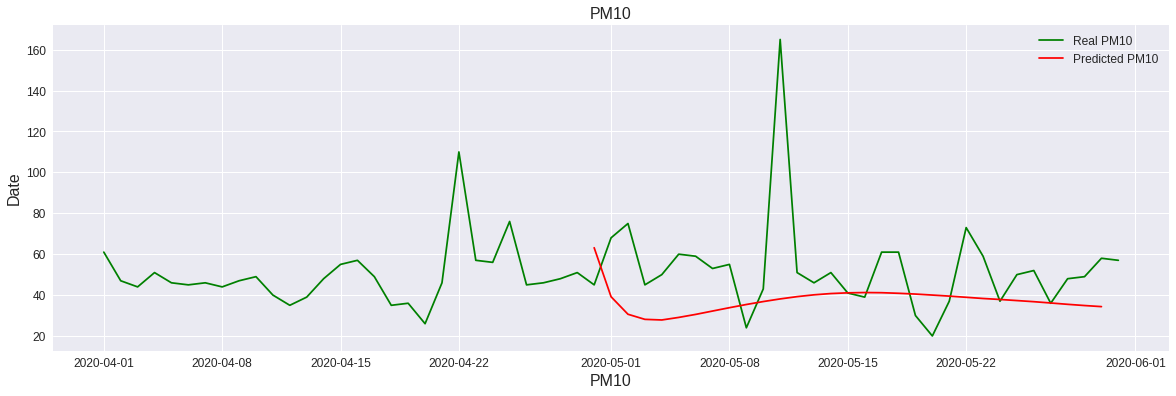

In [139]:
plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(forecast_datesA, forecastA2, 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

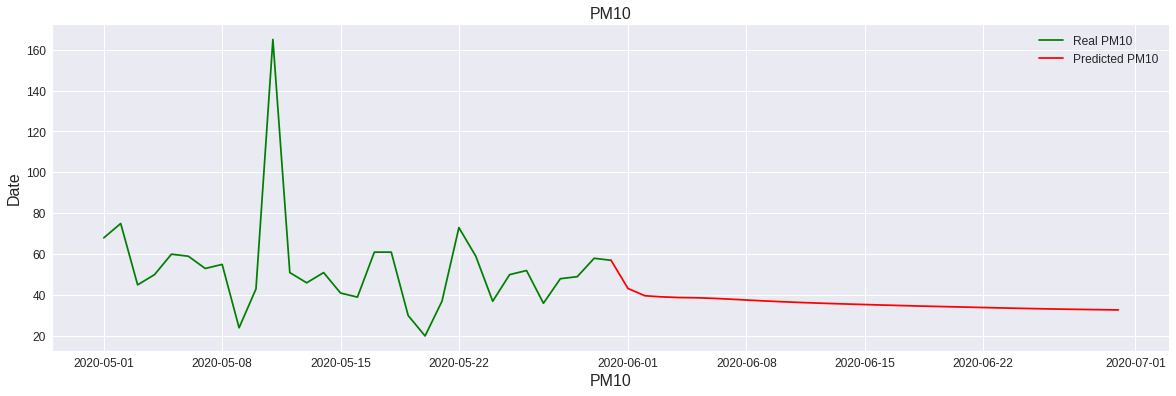

In [140]:
plt.figure(figsize = (20,6))
plt.plot(tempB.index.values[-31:],tempB[-31:],'g', label='Real PM10')
plt.plot(forecast_datesB, forecastB2, 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

In [141]:
result1 = pd.DataFrame(outT2[:30])
result1.to_excel("many_to_many.xlsx")

In [142]:
result2 = pd.DataFrame(forecastB2)
result2.to_excel("many_to_one.xlsx")

# 슬라이딩 윈도우 방식으로

In [143]:
data_train=training_data_drop['PM10'].reset_index()
data_train.columns=['ds','y']

In [144]:
model=Prophet()
model.fit(data_train) ##Fitting our data

future=model.make_future_dataframe(periods=365)
predict=model.predict(future)

In [145]:
future

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
2589,2021-05-27
2590,2021-05-28
2591,2021-05-29
2592,2021-05-30


In [146]:
predict_2020=predict[(predict['ds']>'2019-12-31') & (predict['ds']<'2020-8-01')][['ds','trend']]
predict_2020=predict_2020.set_index('ds',drop=True)

Xt=training_data_drop['2020':]
new=Xt.join(predict_2020)
linear_prediction=new['trend'].values.reshape(len(new),1)

In [147]:
test_dataset = training_data_drop['2020':]
Real_PM_data = test_dataset.iloc[:,0:1].values

In [148]:
test_dataset.shape

(152, 6)

In [149]:
Real_PM_data.shape

(152, 1)

In [150]:
total_dataset=pd.concat((training_dataset['PM10'],test_dataset['PM10']),axis=0)
inputs=total_dataset.iloc[len(total_dataset)-len(test_dataset)-60:].values
inputs=inputs.reshape(-1,1)

inputs=sc.transform(inputs)

X_test=[]
for i in range(60,(60+len(Real_PM_data))):
    X_test.append(inputs[i-60:i,0])
    
X_test= np.array(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

predicted_pm10_values=regressor.predict(X_test)
predicted_pm10_values=sc.inverse_transform(predicted_pm10_values)

In [151]:
len(Real_PM_data)

152

In [152]:
predicted_pm10_values.shape

(152, 1)

In [153]:
Year_2020=pd.DataFrame(np.concatenate((Real_PM_data, predicted_pm10_values,linear_prediction),axis=1),index=test_dataset.index,columns=['Real','Predicted','Linear'])
Year_2020.index = pd.to_datetime(Year_2020.index)
Year_2020.tail()

,Real,Predicted,Linear
날짜,,,
2020-05-27,36.0,41.729401,39.171138
2020-05-28,48.0,36.891087,39.165575
2020-05-29,49.0,47.030174,39.160011
2020-05-30,58.0,41.044579,39.154448
2020-05-31,57.0,49.402058,39.148885


In [154]:
groups_real = Year_2020['Real'].groupby(pd.Grouper(freq='M'))
groups_predict = Year_2020['Predicted'].groupby(pd.Grouper(freq='M'))

months_real = pd.concat([pd.DataFrame(x[1].values) for x in groups_real], axis=1)
months_predict = pd.concat([pd.DataFrame(x[1].values) for x in groups_predict], axis=1)

months_real = pd.DataFrame(months_real)
months_predict = pd.DataFrame(months_predict)

months_real.columns = ['Jan','Feb','Mar','Apr','May']
months_predict.columns = ['Jan','Feb','Mar','Apr','May']

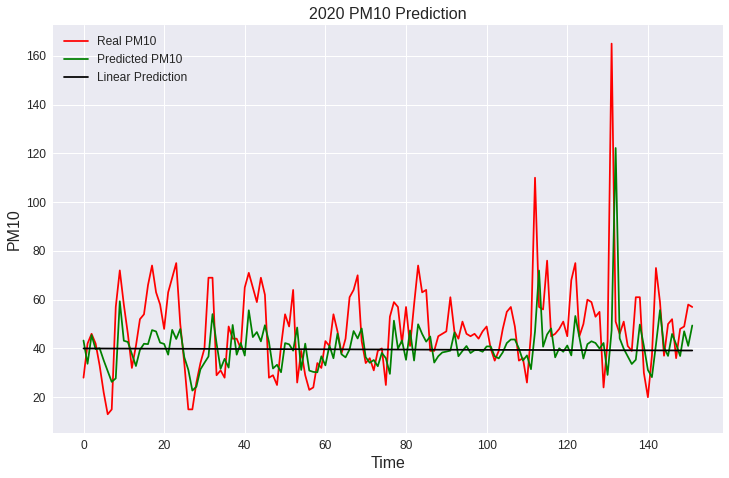

In [155]:
plt.figure(figsize=(12,7.5))
plt.plot(Real_PM_data,color='red',label='Real PM10')
plt.plot(predicted_pm10_values,color='green',label='Predicted PM10')
plt.plot(linear_prediction,color='black',label='Linear Prediction')
plt.title('2020 PM10 Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PM10')
plt.show()

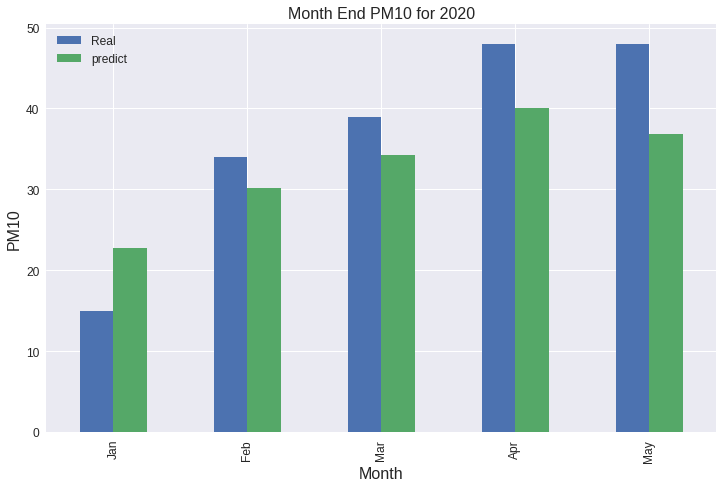

In [156]:
mon=pd.DataFrame({'Real':months_real[27:28].values.ravel(),'predict':months_predict[27:28].values.ravel()},index=months_real[27:28].columns)
mon.plot(kind='bar',figsize=(12,7.5))
plt.xlabel("Month")
plt.ylabel("PM10")
plt.title("Month End PM10 for 2020")
plt.show()

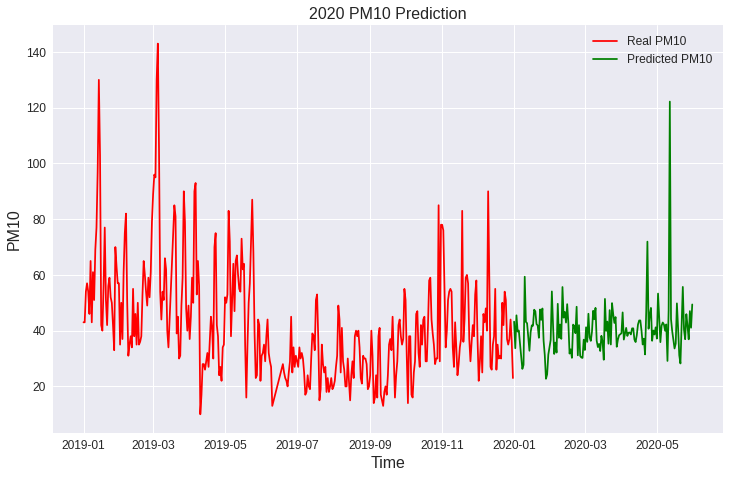

In [157]:
plt.figure(figsize=(12,7.5))
plt.plot(training_data_drop.index[1725:2077],training_data_drop['PM10']['2019':'2019'],color='red',label='Real PM10')
plt.plot(Xt.index,predicted_pm10_values,color='green',label='Predicted PM10')
plt.title('2020 PM10 Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PM10')
plt.show()

In [158]:
training_data_drop['PM10']['2019':'2019'].shape

(352,)

In [162]:
june = pd.read_excel('/kaggle/input/powerstation/2020_6__.xlsx')
june

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소,mean
0,경기 고양시,도시대기,131382,식사동,2020060101,0.003,0.2,0.043,0.006,24.0,8.0,경기 고양시 일산동구 위시티로 151,25.958333
1,경기 고양시,도시대기,131382,식사동,2020060102,0.002,0.2,0.045,0.005,19.0,7.0,경기 고양시 일산동구 위시티로 151,25.958333
2,경기 고양시,도시대기,131382,식사동,2020060103,0.003,0.2,0.045,0.005,16.0,8.0,경기 고양시 일산동구 위시티로 151,25.958333
3,경기 고양시,도시대기,131382,식사동,2020060104,0.002,0.2,0.044,0.005,17.0,6.0,경기 고양시 일산동구 위시티로 151,25.958333
4,경기 고양시,도시대기,131382,식사동,2020060105,0.003,0.2,0.045,0.005,14.0,4.0,경기 고양시 일산동구 위시티로 151,25.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,경기 고양시,도시대기,131382,식사동,2020063020,0.003,0.3,0.032,0.007,12.0,1.0,경기 고양시 일산동구 위시티로 151,20.208333
716,경기 고양시,도시대기,131382,식사동,2020063021,0.003,0.3,0.029,0.008,15.0,1.0,경기 고양시 일산동구 위시티로 151,20.208333
717,경기 고양시,도시대기,131382,식사동,2020063022,0.003,0.3,0.028,0.008,12.0,1.0,경기 고양시 일산동구 위시티로 151,20.208333
718,경기 고양시,도시대기,131382,식사동,2020063023,0.003,0.3,0.024,0.010,11.0,1.0,경기 고양시 일산동구 위시티로 151,20.208333


In [169]:
june_list = list(june['mean'].unique())

<function matplotlib.pyplot.show(*args, **kw)>

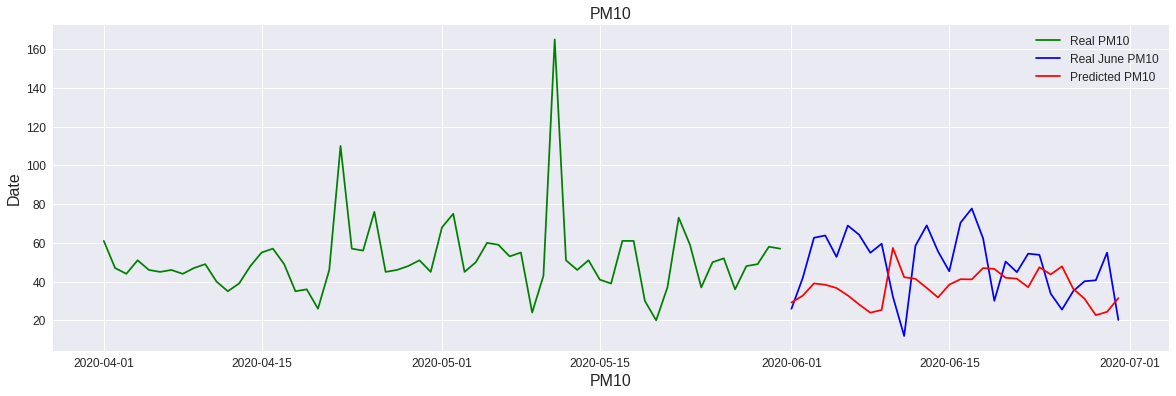

In [170]:
plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_list,'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

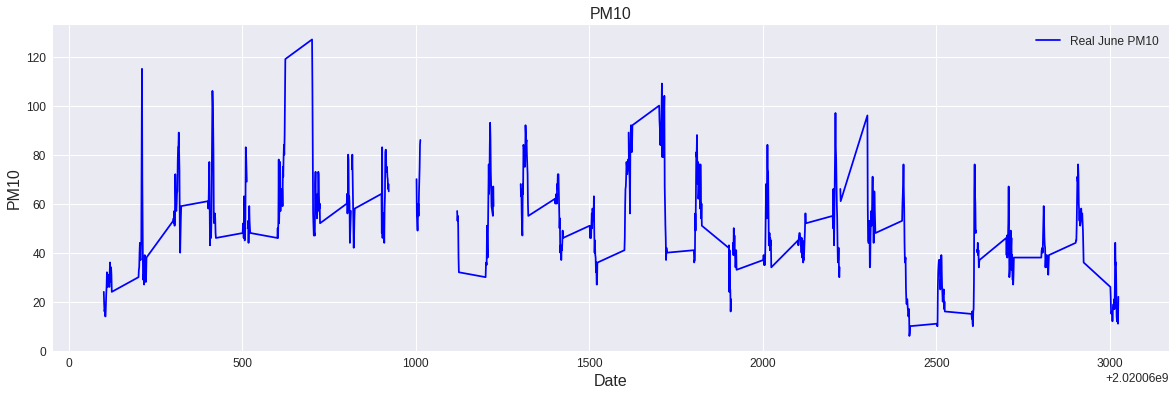

In [174]:
plt.figure(figsize = (20,6))
plt.plot(june['측정일시'],june['PM10'],'b',label = 'Real June PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('Date')
plt.ylabel('PM10')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

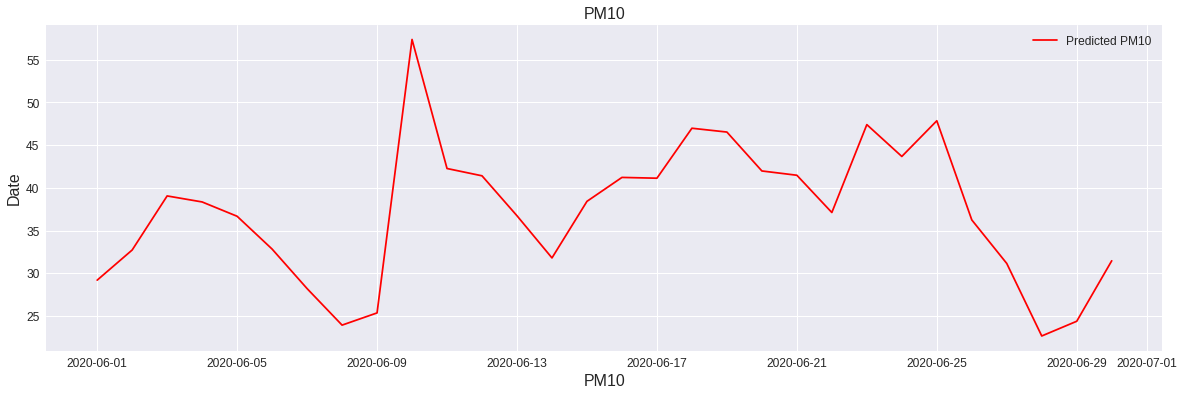

In [175]:
plt.figure(figsize = (20,6))
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

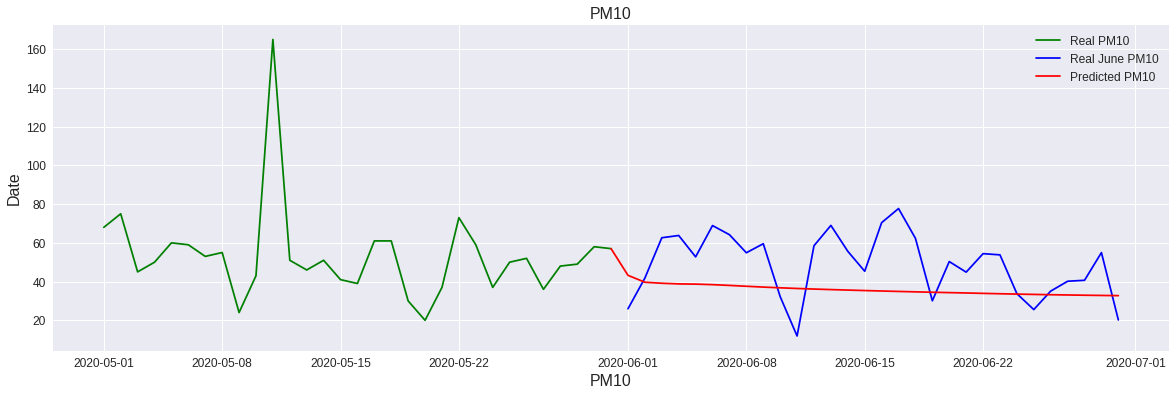

In [171]:
plt.figure(figsize = (20,6))
plt.plot(tempB.index.values[-31:],tempB[-31:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_list,'b',label = 'Real June PM10')
plt.plot(forecast_datesB, forecastB2, 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

In [185]:
list_june_01 = []
for x in june['측정일시'] :
    if str(x)[-2:] == '01' :
        list_june_01.append(x)
    else :
        pass

june_01 = june[june['측정일시'].isin(list_june_01)]

<function matplotlib.pyplot.show(*args, **kw)>

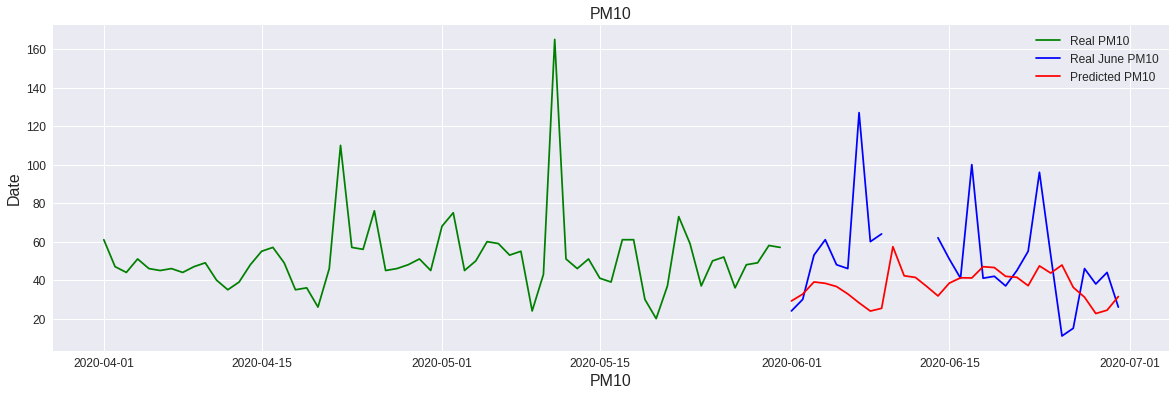

In [190]:
plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_01['PM10'],'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

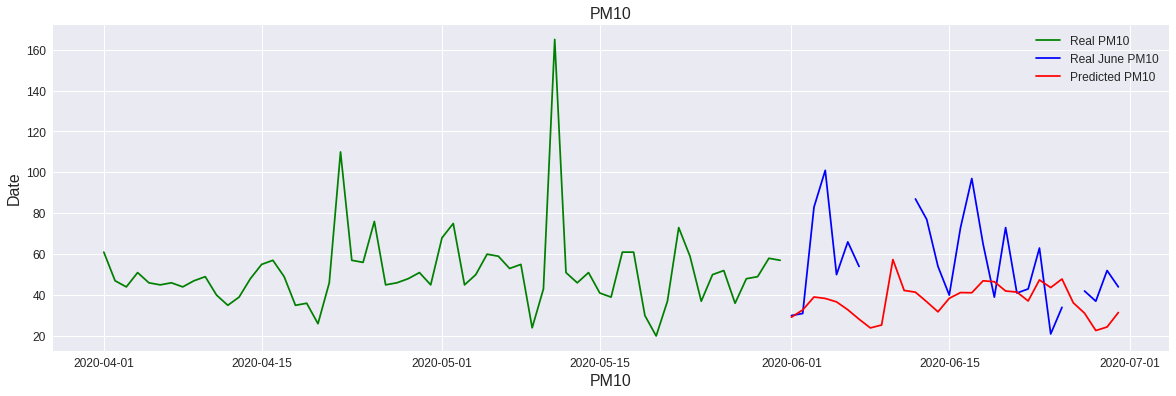

In [191]:
list_june_15 = []
for x in june['측정일시'] :
    if str(x)[-2:] == '15' :
        list_june_15.append(x)
    else :
        pass

june_15 = june[june['측정일시'].isin(list_june_15)]

plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_15['PM10'],'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

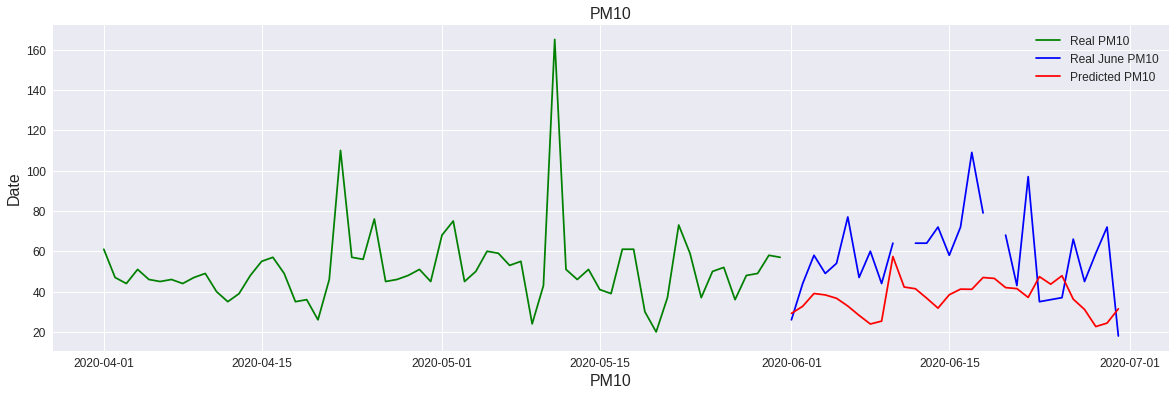

In [192]:
list_june_09 = []
for x in june['측정일시'] :
    if str(x)[-2:] == '09' :
        list_june_09.append(x)
    else :
        pass

june_09 = june[june['측정일시'].isin(list_june_09)]

plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_09['PM10'],'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

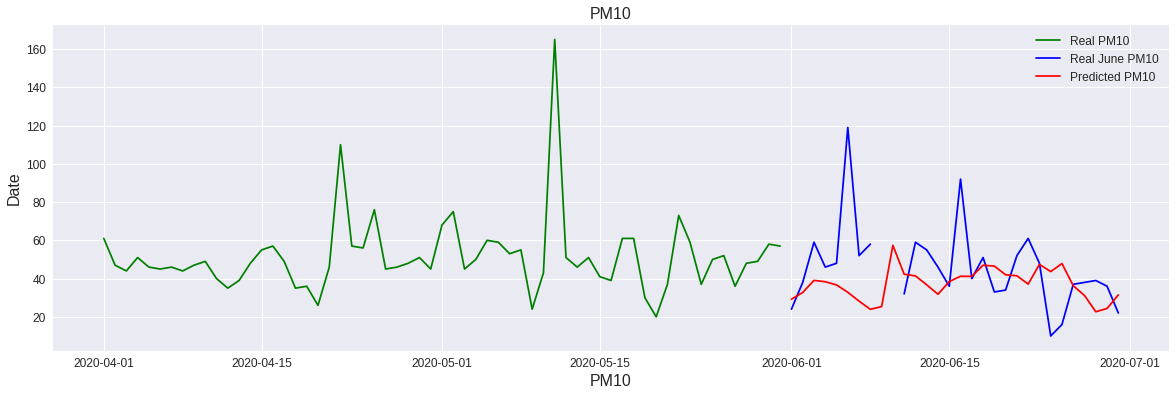

In [193]:
list_june_24 = []
for x in june['측정일시'] :
    if str(x)[-2:] == '24' :
        list_june_24.append(x)
    else :
        pass

june_24 = june[june['측정일시'].isin(list_june_24)]

plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_24['PM10'],'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

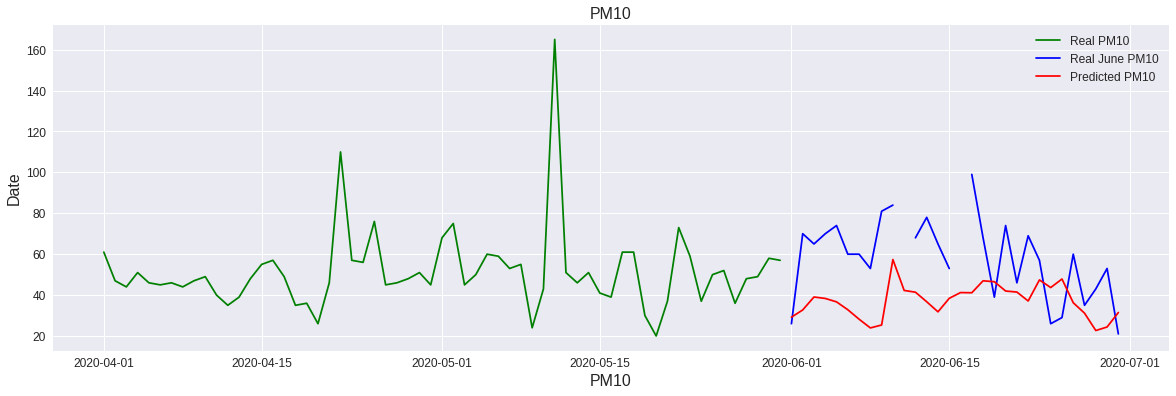

In [194]:
list_june_12 = []
for x in june['측정일시'] :
    if str(x)[-2:] == '12' :
        list_june_12.append(x)
    else :
        pass

june_12 = june[june['측정일시'].isin(list_june_12)]

plt.figure(figsize = (20,6))
plt.plot(training_dataset['2020':]['PM10'][-61:].index.values,training_dataset['2020':]['PM10'][-61:],'g', label='Real PM10')
plt.plot(outT_datesBT[:30],june_12['PM10'],'b',label = 'Real June PM10')
plt.plot(outT_datesBT[:30], outT2[:30], 'r',label='Predicted PM10')
plt.legend()
plt.title("PM10")
plt.xlabel('PM10')
plt.ylabel('Date')
plt.show

In [213]:
june_12['PM10']

11     26.0
35     70.0
59     65.0
83     70.0
107    74.0
131    60.0
155    60.0
179    53.0
203    81.0
227    84.0
251     NaN
275    68.0
299    78.0
323    65.0
347    53.0
371     NaN
395    99.0
419    68.0
443    39.0
467    74.0
491    46.0
515    69.0
539    57.0
563    26.0
587    29.0
611    60.0
635    35.0
659    43.0
683    53.0
707    21.0
Name: PM10, dtype: float64

In [210]:
predidi = []
for x in outT2[:30] :
    predidi.append(x[0])

In [214]:
corre = pd.DataFrame()
corre['PM10_Predict'] = predidi
corre['PM10_June01'] = list(june_01['PM10'])
corre['PM10_June09'] = list(june_09['PM10'])
corre['PM10_June12'] = list(june_12['PM10'])
corre['PM10_June15'] = list(june_15['PM10'])
corre['PM10_June24'] = list(june_24['PM10'])

In [216]:
corre.corr()

,PM10_Predict,PM10_June01,PM10_June09,PM10_June12,PM10_June15,PM10_June24
PM10_Predict,1.000000,-0.075285,0.107252,0.162626,0.148458,-0.091380
PM10_June01,-0.075285,1.000000,0.200702,0.423250,0.349449,0.179715
PM10_June09,0.107252,0.200702,1.000000,0.680828,0.467152,0.466928
PM10_June12,0.162626,0.423250,0.680828,1.000000,0.735209,0.452709
PM10_June15,0.148458,0.349449,0.467152,0.735209,1.000000,0.459394
PM10_June24,-0.091380,0.179715,0.466928,0.452709,0.459394,1.000000
